# ISA $\alpha=2$

Ok, let's check this one out and evaluate the performance with my beautiful new plots!

### Load model, make data etc.

In [1]:
import torch
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mlp
from mpl_toolkits.axes_grid1 import make_axes_locatable

import json, yaml, os
os.sys.path.append('./../../code')

from plotting import plot_kslots, plot_kslots_iters
from data import make_batch
from model import InvariantSlotAttention

from matplotlib.patches import Circle
import json

# Set numpy seed for test set sampling 
np.random.seed(24082023)

%load_ext autoreload
%autoreload 2

In [2]:
device = 'cpu'

In [3]:
cID_prev = 'isa-alpha2'
with open(f'./../../code/configs/{cID_prev}.yaml') as f:
    cd = yaml.safe_load(f)

hps = cd['hps']
hps['device'] = device

In [4]:
torch_seed = 24082023
torch.manual_seed( torch_seed )

import random
random.seed(torch_seed)

In [5]:
m = InvariantSlotAttention(**hps)

**At what iteration load the model**? -> Have a look at the loss

In [6]:
f = open(f'./../../code/models/{cID_prev}/loss.json')
# returns JSON object as a dictionary
losses = json.load(f)

loss  tot  min:  0.0962183028459549  at  997
loss  bce  min:  0.05043430253863335  at  997
loss  mse  min:  0.020835330709815025  at  954


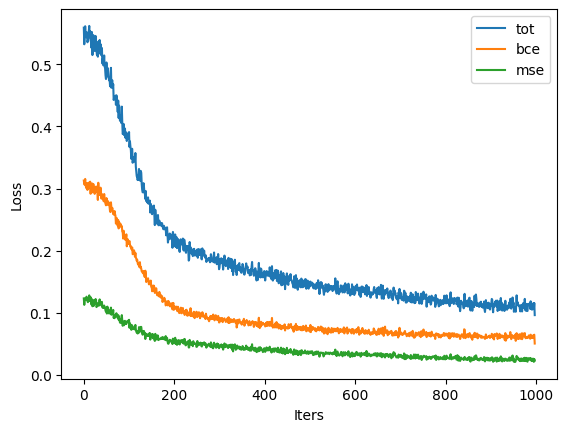

In [7]:
for k,v in losses.items():
    plt.plot(v,label=k)
    print("loss ", k, " min: ", np.min(v), " at ", np.argmin(v))
plt.xlabel('Iters')
plt.ylabel('Loss')
plt.legend()
plt.show()

choose 11000!

In [8]:
lastIter = 6000
weightPath = f'./../../code/models/{cID_prev}/m_{lastIter}.pt'
print(f'Starting from an earlier training',lastIter)

m.load_state_dict(torch.load(weightPath,map_location=device))

Starting from an earlier training 6000


<All keys matched successfully>

In [9]:
bs = 1000
kwargs = cd['data']

X, Y, mask = make_batch(N_events=bs, **kwargs)

/raven/u/saumi/multi-object-detection/Slot-Attention/Notebooks/Invariant-Slot-Attention (ISA) methods/./../../code/data.py:94: RuntimeWarning: invalid value encountered in divide
  eventMasks = np.where(eventHistograms>0,eventMasks/eventHistograms,eventMasks)


### Evaluate the model

In [10]:
from train import hungarian_matching
import torch.nn.functional as F

k_slots=3
max_n_rings=2
resolution=(32,32)

In [11]:
alpha = cd['opt']['alpha']

In [12]:
with torch.no_grad():

    torch.manual_seed(torch_seed)
    queries, att, Y_pred = m(X)
         
    # Reshape the target mask to be flat in the pixels (same shape as att)
    flat_mask = mask.reshape(-1,max_n_rings, np.prod(resolution))      

    att_ext  = torch.tile(att.unsqueeze(2), dims=(1,1,max_n_rings,1)) 
    mask_ext = torch.tile(flat_mask.unsqueeze(1),dims=(1,k_slots,1,1)) 

    pairwise_cost = F.binary_cross_entropy(att_ext,mask_ext,reduction='none').mean(axis=-1)

    # pairwise_cost = comb_loss(att,flat_mask,Y,Y_pred,alpha)
    indices = hungarian_matching(pairwise_cost)

    # Apply the sorting to the predict
    bis=torch.arange(bs).to(device)
    indices=indices.to(device)

    # Loss calc
    slots_sorted = torch.cat([att[bis,indices[:,0,ri]].unsqueeze(1) for ri in range(max_n_rings)],dim=1)
    rings_sorted = torch.cat([flat_mask[bis,indices[:,1,ri]].unsqueeze(1) for ri in range(max_n_rings)],dim=1)
    l_bce = F.binary_cross_entropy(slots_sorted,rings_sorted,reduction='none').sum(axis=1).mean(axis=-1)

    Y_pred_sorted = torch.cat([Y_pred[bis,indices[:,0,ri]].unsqueeze(1) for ri in range(max_n_rings)],dim=1)
    Y_true_sorted = torch.cat([Y[bis,indices[:,1,ri]].unsqueeze(1) for ri in range(max_n_rings)],dim=1)

    l_mse = torch.nn.MSELoss(reduction='none')(Y_pred_sorted,Y_true_sorted).sum(axis=1).mean(axis=-1)

    # Calculate the loss
    print(l_bce.shape)
    print(l_mse.shape)
    li = l_bce + alpha*l_mse
    

torch.Size([1000])
torch.Size([1000])


### Look at examples

In [13]:
def plot_chosen_slots_only(mask, att_img, Y_true, Y_pred, color='C0',cmap='Blues',figname=''):
    n_rings = att_img.shape[0]
    fig, axs = plt.subplots(1,n_rings+1,figsize=(3*(n_rings + 2) ,2.5))
   
    imgs   = [mask] + [att_img[i] for i in range(n_rings)]
    titles = ['Target']+[f'Slot {i}' for i in range(n_rings)]
    extent = [-0.5, 0.5]*2
    for i, (ax,img,title) in enumerate(zip(axs[0:],imgs, titles)):
        
        im = ax.imshow(img.detach().cpu().numpy(),cmap=cmap,
                       extent=extent,origin='lower') #,vmin=0,vmax=1)

        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im, cax=cax, orientation='vertical')

        ax.set_title(title)
        

    # Add on the target image
    axi = axs[0]
    c_true = 'r'
    c_pred = 'k'
    for yi in Y_true.cpu().numpy():
    
        axi.scatter(*yi[:2],marker='x',color=c_true)
        circle = Circle(yi[:2],yi[2],fill=False,color=c_true)
        axi.add_patch(circle)
        
        axi.set_xlim(-0.5,0.5)
        axi.set_ylim(-0.5,0.5)
    
    for axi,yi,oi in zip(axs[1:],Y_true.cpu().numpy(),Y_pred.detach().cpu().numpy()):
        
        axi.scatter(*yi[:2],marker='x',color=c_true)
        circle = Circle(yi[:2],yi[2],fill=False,color=c_true)
        axi.add_patch(circle)
        
        axi.scatter(*oi[:2],marker='x',color=c_pred)
        circle = Circle(oi[:2],oi[2],fill=False,color=c_pred)
        axi.add_patch(circle)

        axi.set_xlim(-0.5,0.5)
        axi.set_ylim(-0.5,0.5)
        
    #if figname:
    #    plt.savefig(figname)

    plt.show()
    plt.close()

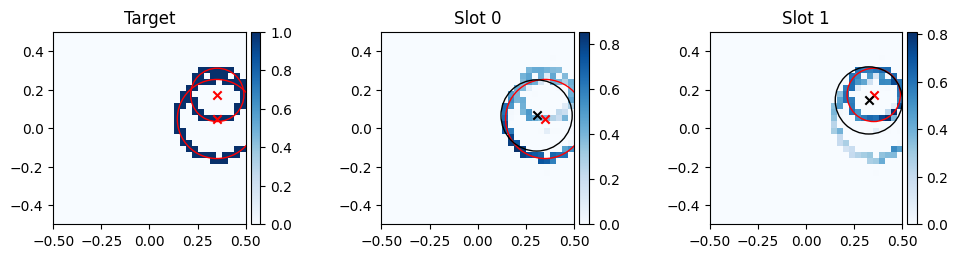

In [14]:
iEvt = 8

plot_chosen_slots_only(
                  mask[iEvt].sum(axis=0), 
                  slots_sorted[iEvt].reshape(max_n_rings,*resolution),
                  Y_true_sorted[iEvt],
                  Y_pred_sorted[iEvt])

ok this looks cool! Slot 1 looks good at it does learn more than center of gravity for x,y,R!

Check KL-divergence and good and bad examples!

In [15]:
l_kl = F.kl_div(torch.log(slots_sorted),rings_sorted,reduction='none').sum(axis=1).mean(axis=-1)

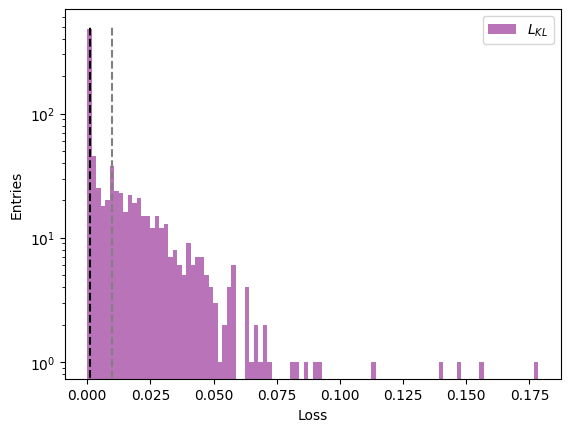

In [16]:
plt.hist(l_kl.numpy(),100,color='purple', label="$L_{KL}$", alpha=0.55)


#plt.hist(l_bce.numpy(),100,color='r', label="$L_{BCE}$", alpha=0.55, range=(0, 0.35))
plt.xlabel('Loss')
plt.ylabel('Entries')

ylim = plt.ylim()
plt.plot([.001]*2,ylim,'k--')
plt.plot([.01]*2,ylim,'grey',ls='--')

plt.legend()
plt.yscale("log")

plt.show()

In [17]:
mi = l_kl < 0.001 # good events
torch.sum(mi)
mj = l_kl > 0.01 # bad events
torch.sum(mj)

good_imgs = mask[mi].sum(axis=1)
bad_imgs  = mask[mj].sum(axis=1)

**Bad examples**

KL:  tensor(0.0201)


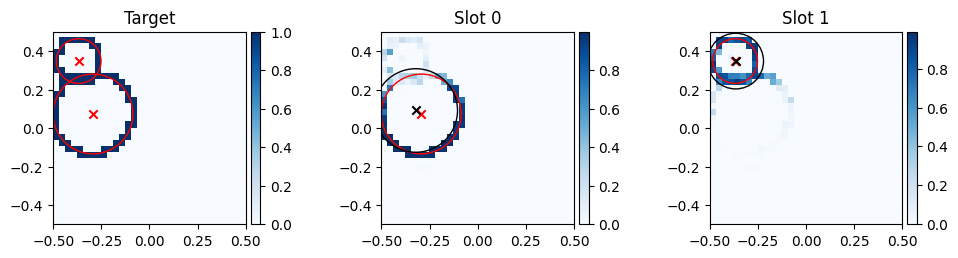

KL:  tensor(0.0418)


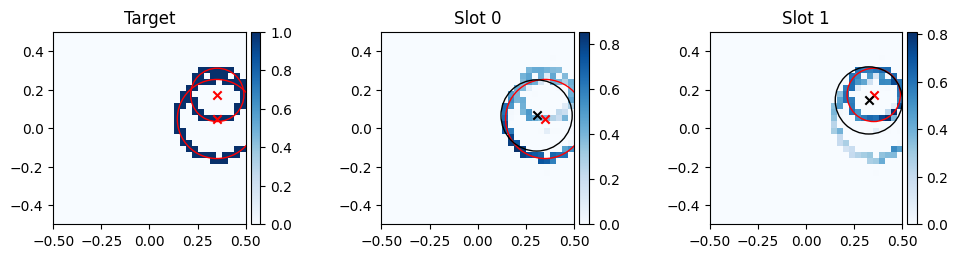

KL:  tensor(0.0214)


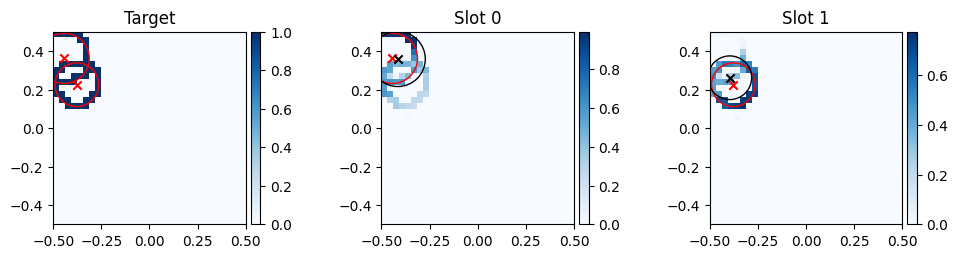

KL:  tensor(0.0561)


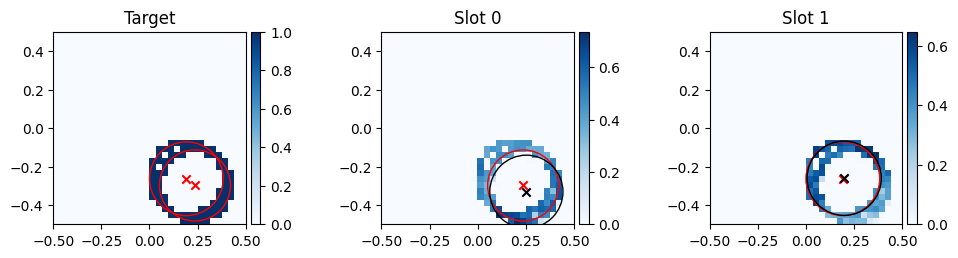

KL:  tensor(0.0161)


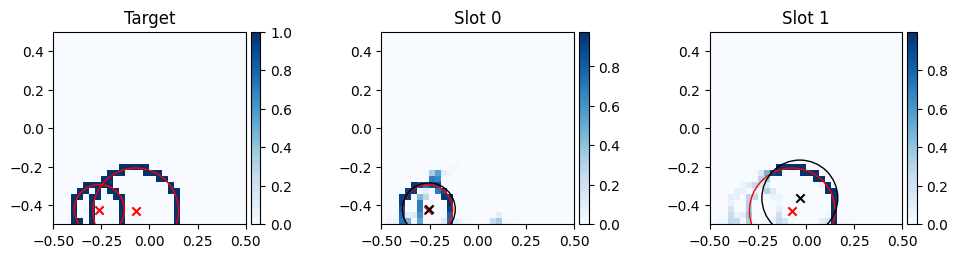

KL:  tensor(0.0270)


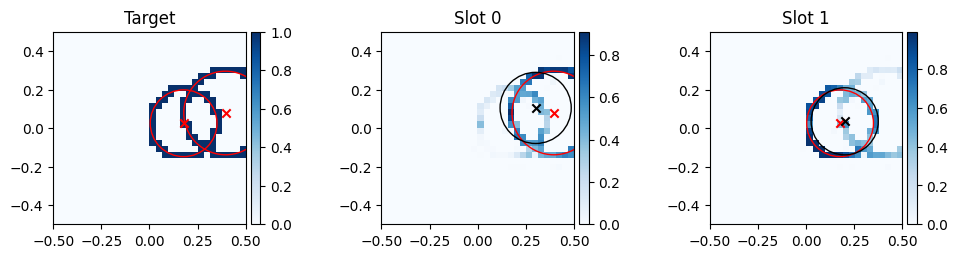

KL:  tensor(0.0654)


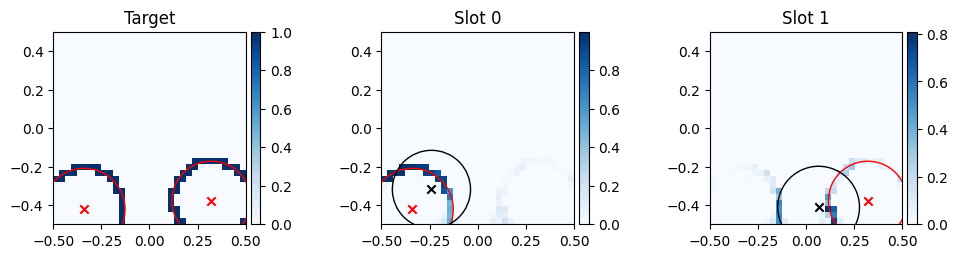

KL:  tensor(0.0418)


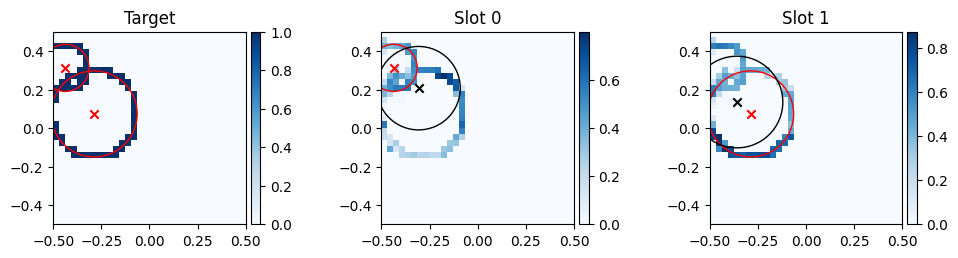

KL:  tensor(0.0710)


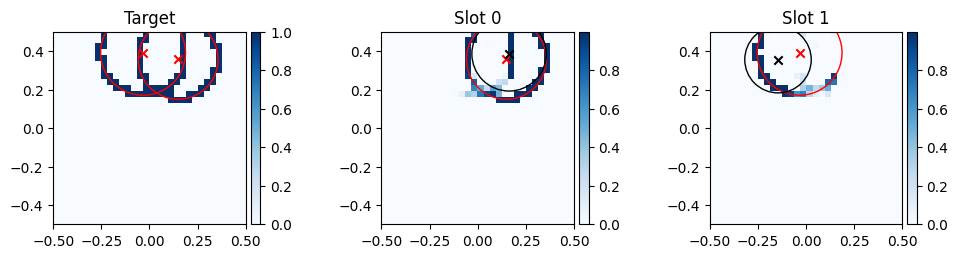

KL:  tensor(0.0222)


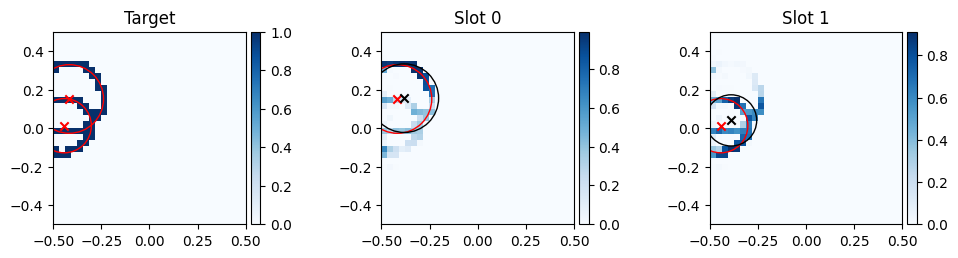

KL:  tensor(0.0195)


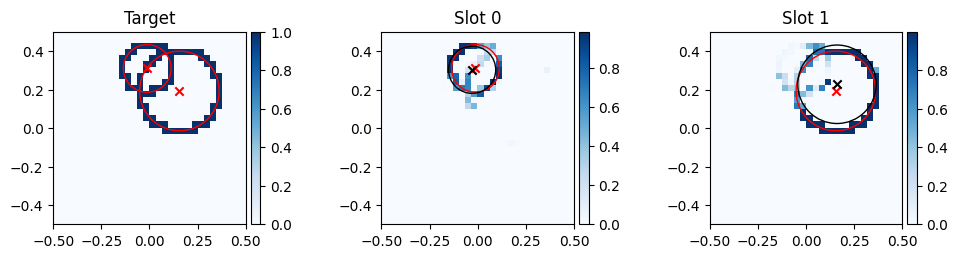

KL:  tensor(0.0221)


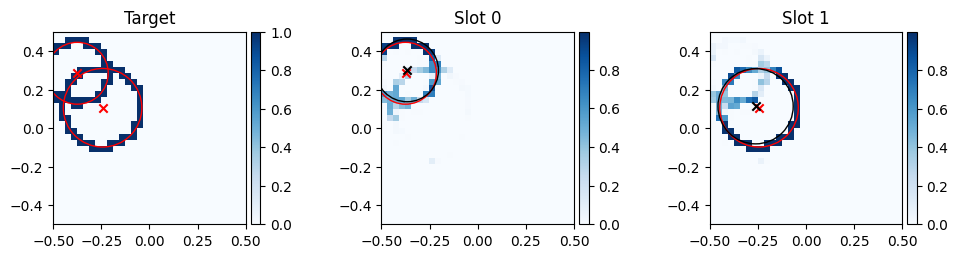

KL:  tensor(0.0190)


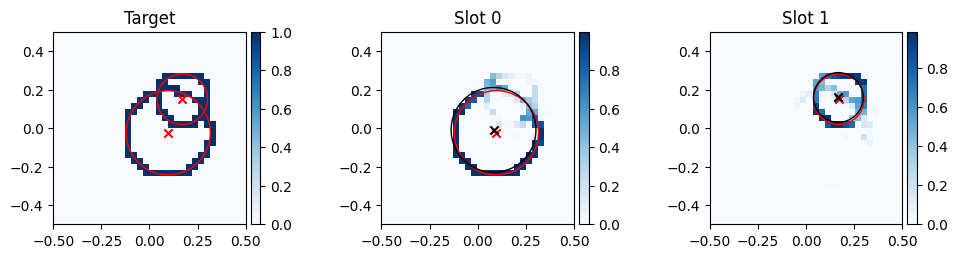

KL:  tensor(0.0414)


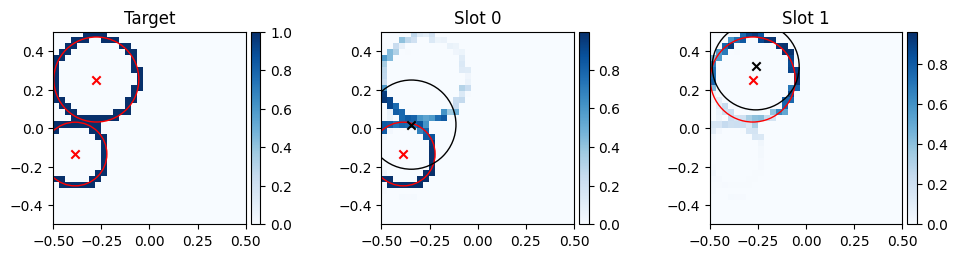

KL:  tensor(0.1125)


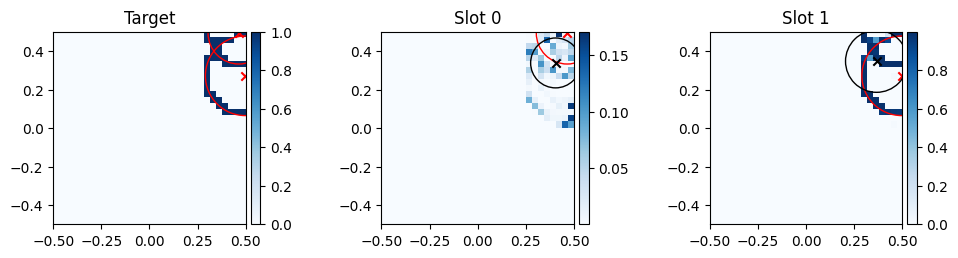

KL:  tensor(0.0227)


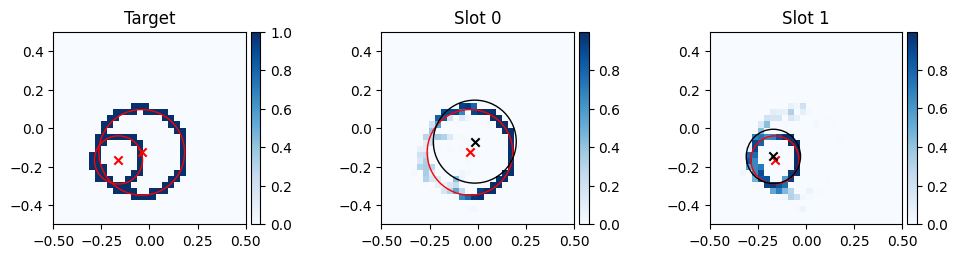

KL:  tensor(0.0499)


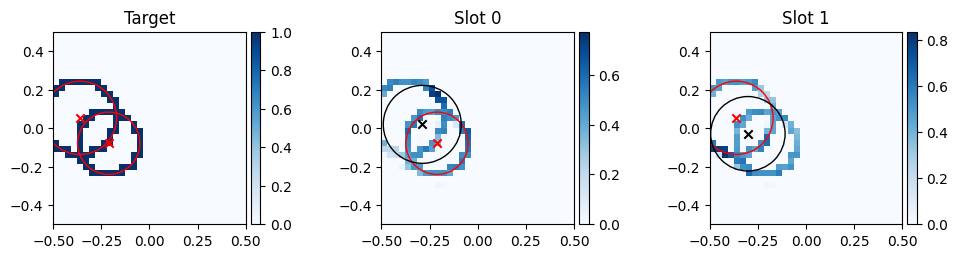

In [18]:
for count, k in enumerate(np.where(l_kl > 0.01)[0]):
    iEvt = k
    print("KL: ", l_kl[iEvt])
    plot_chosen_slots_only(
                  mask[iEvt].sum(axis=0), 
                  slots_sorted[iEvt].reshape(max_n_rings,*resolution),
                  Y_true_sorted[iEvt],
                  Y_pred_sorted[iEvt])
    if count>15:
        break

**Good expamles**

KL:  tensor(0.0003)


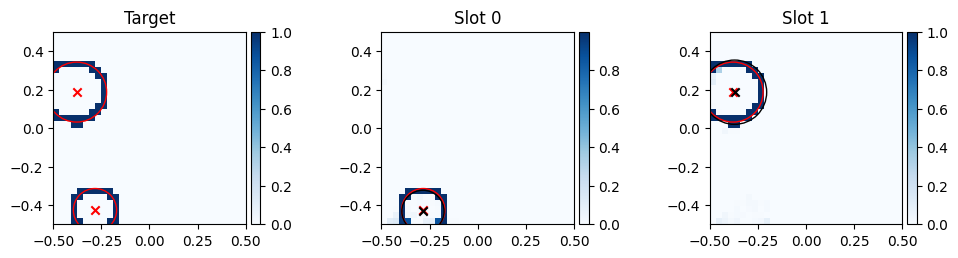

KL:  tensor(0.0003)


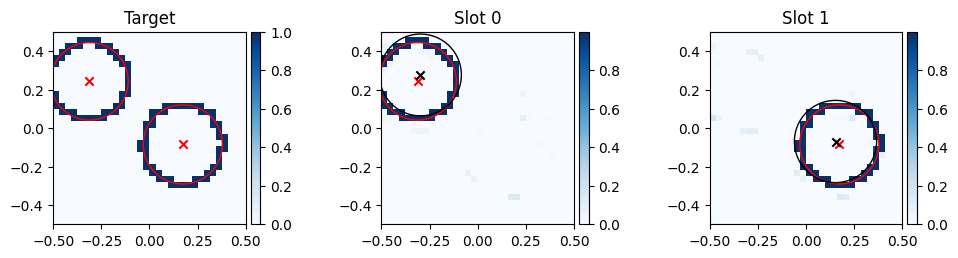

KL:  tensor(2.5505e-05)


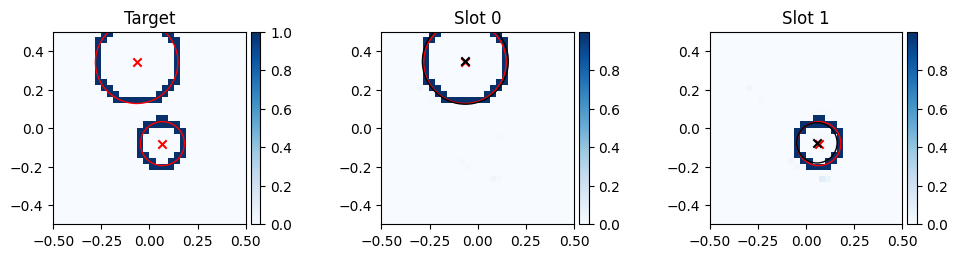

KL:  tensor(3.4606e-06)


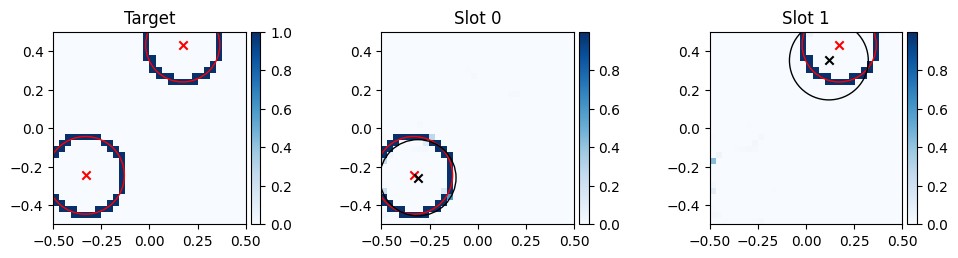

KL:  tensor(0.0003)


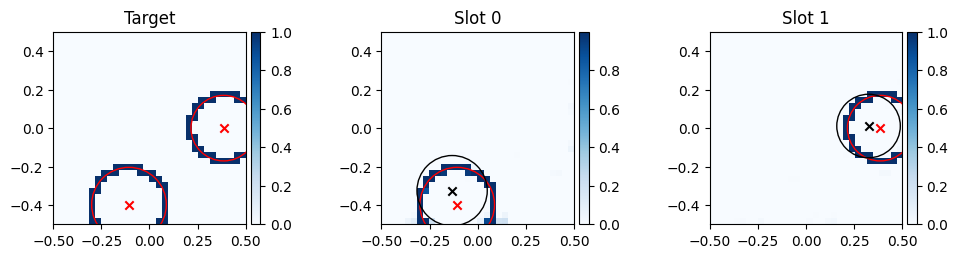

KL:  tensor(0.0002)


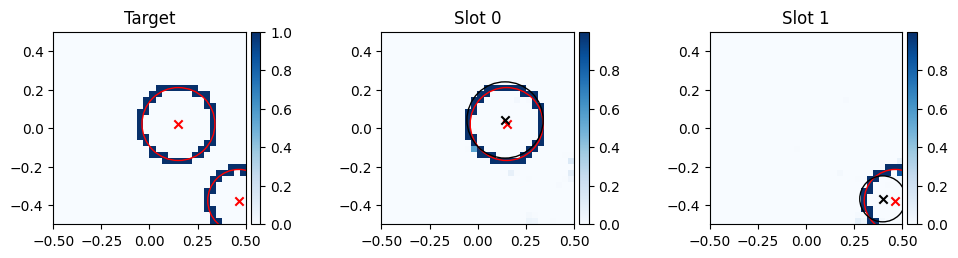

KL:  tensor(1.7373e-05)


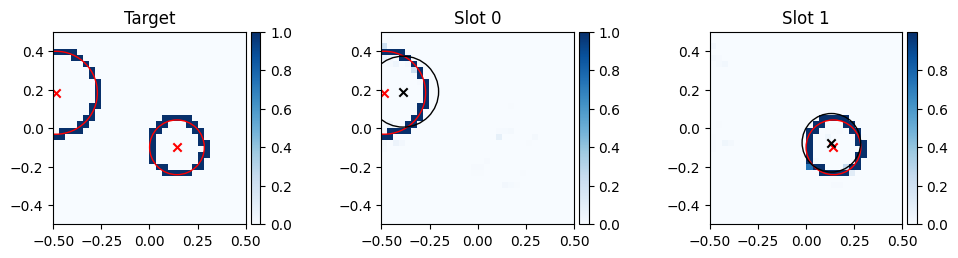

KL:  tensor(5.9951e-07)


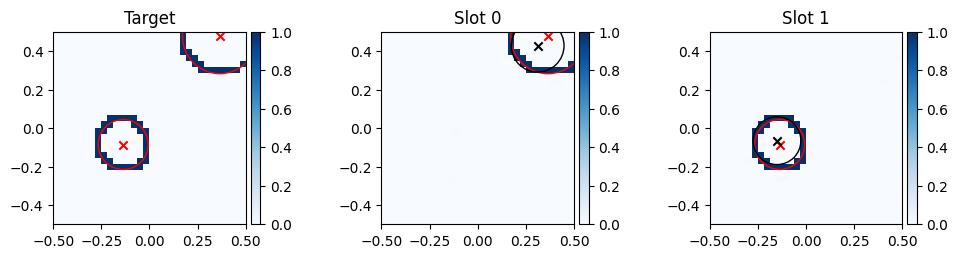

KL:  tensor(0.0002)


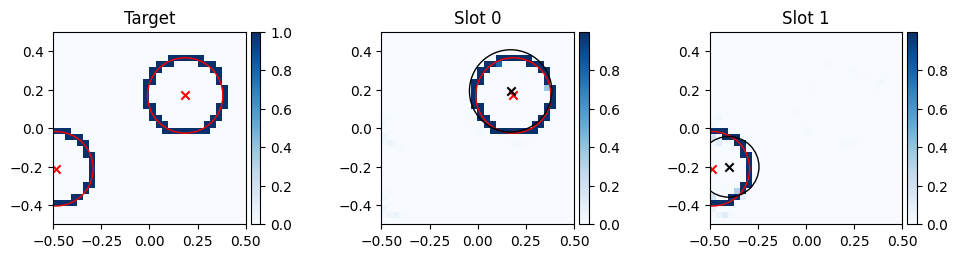

KL:  tensor(2.9376e-05)


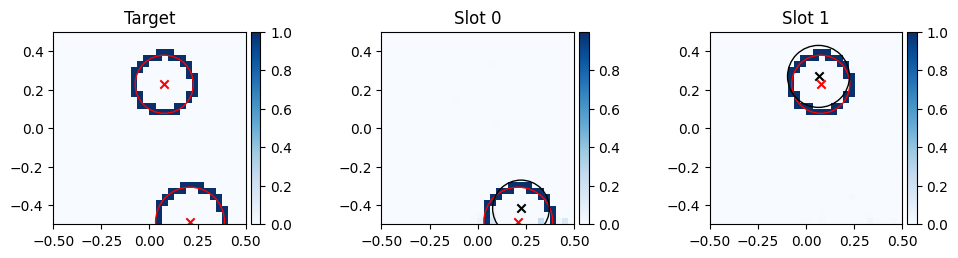

KL:  tensor(7.0709e-07)


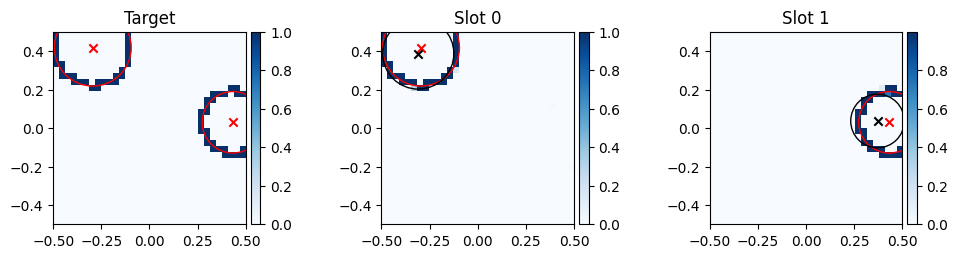

KL:  tensor(5.4328e-07)


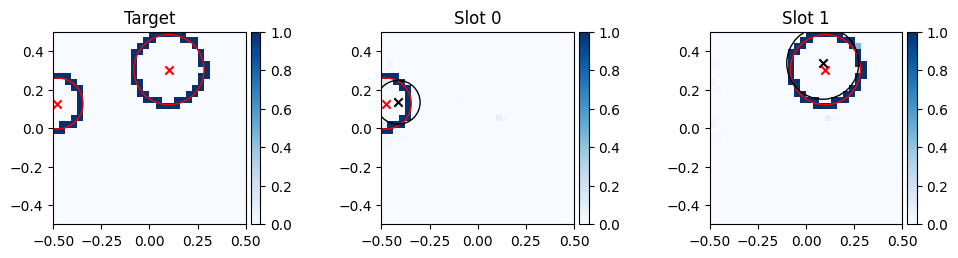

KL:  tensor(3.1291e-06)


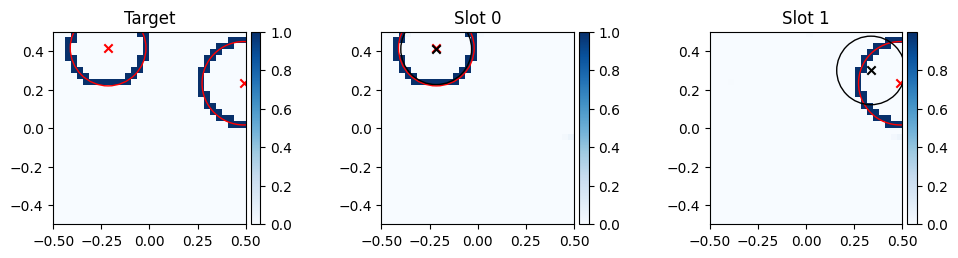

KL:  tensor(9.4003e-05)


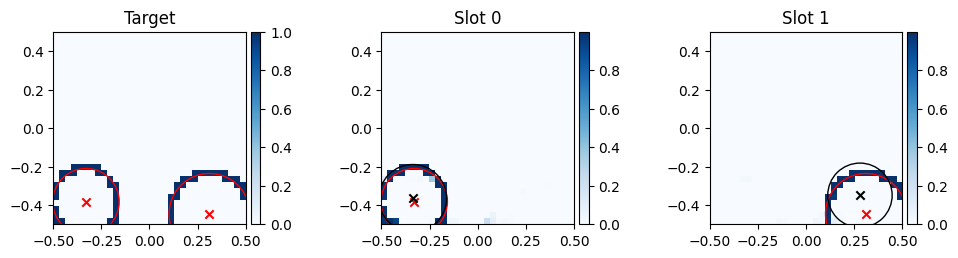

KL:  tensor(8.8763e-05)


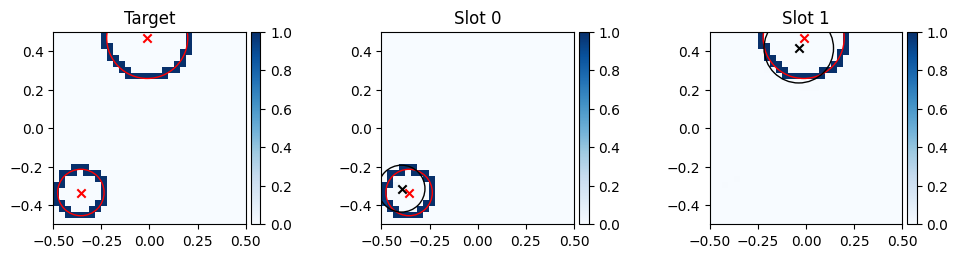

KL:  tensor(2.5400e-05)


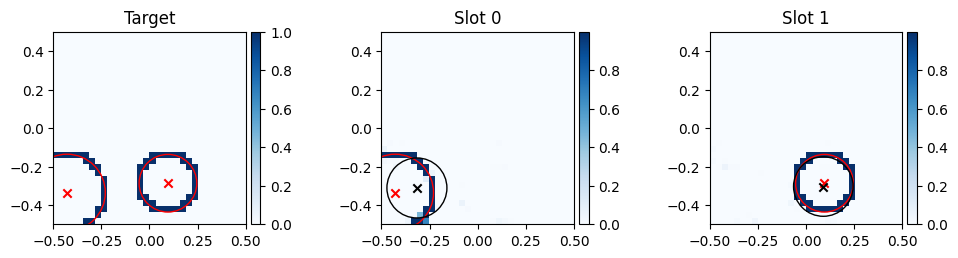

KL:  tensor(4.9485e-05)


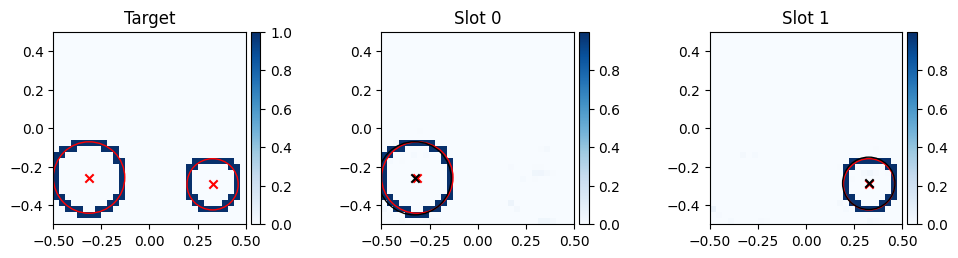

In [19]:
for count, k in enumerate(np.where(l_kl < 0.001)[0]):
    iEvt = k
    print("KL: ", l_kl[iEvt])
    plot_chosen_slots_only(
                  mask[iEvt].sum(axis=0), 
                  slots_sorted[iEvt].reshape(max_n_rings,*resolution),
                  Y_true_sorted[iEvt],
                  Y_pred_sorted[iEvt])
    if count>15:
        break

# Evalutation - KL-divergence and student t

We settled to use the 
- KL-divergence for the goodness of separation
- student-t fit over x,y,E resolution.

Let's implement functions!!

In [39]:
def KL_divergence(slots_sorted, rings_sorted):
    l_kl = F.kl_div(torch.log(slots_sorted),rings_sorted,reduction='none').sum(axis=1).mean(axis=-1)
    l_kl = np.nan_to_num(l_kl)
    plt.hist(l_kl, bins=70)
    plt.yscale('log')
    plt.xlabel("KL-divergence")
    plt.ylabel("counts")
    plt.show()
    return np.mean(l_kl)

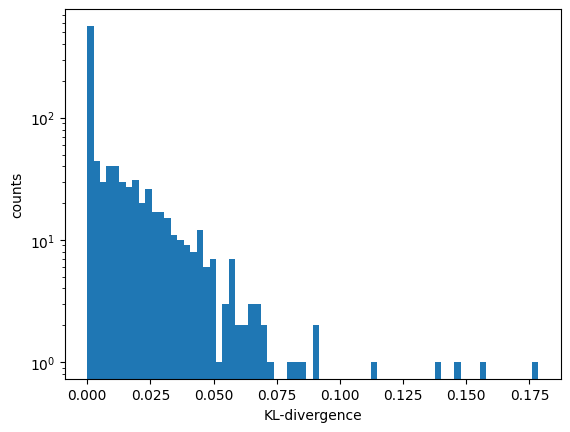

0.010562904

In [25]:
KL_divergence(slots_sorted, rings_sorted) # average KL-divergence over the data====

In [32]:
from scipy.stats import t
from scipy import stats
from scipy.optimize import curve_fit

In [33]:
plt.style.use('standard_style.mlpstyle')

# Evaluation with script $\alpha=2$

In [37]:
import evaluation as ev

KL-divergence:  0.010562904


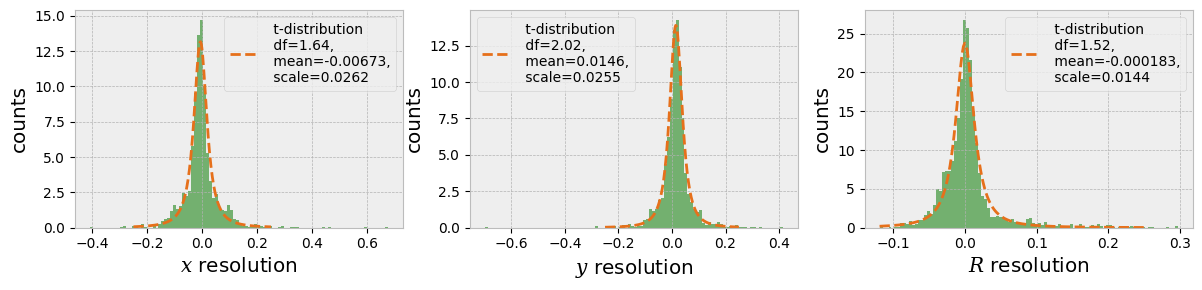

In [38]:
print("KL-divergence: ", ev.KL_divergence(slots_sorted, rings_sorted))
ev.student_t(Y_pred_sorted, Y_true_sorted)